In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import os

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt

# Reading the Data

## Feature Data

In [3]:
# Data file names
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

#There are mov files for different datas, I'll add all of them here latter 
movs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_GRELHA E EIXOS")
movs_2022_09 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv")
movs_2022_10 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv")
movs_2022_11 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv")

# Read data of each month
df_movs_2022_09= pd.read_csv(movs_2022_09, parse_dates=["Datetime"])
df_movs_2022_10= pd.read_csv(movs_2022_10, parse_dates=["Datetime"])
df_movs_2022_11= pd.read_csv(movs_2022_11, parse_dates=["Datetime"])

# Join the 3 months' dataframes:
df_movs = pd.concat([df_movs_2022_09, df_movs_2022_10, df_movs_2022_11])
del(df_movs_2022_09, df_movs_2022_10, df_movs_2022_11)

## Grid Info Data

In [80]:
# Read data from the xlsx file
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
grid_geometry = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

In [81]:
# Function to remove extra curly braces and return a valid WKT string
def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

In [82]:
# Remove extra curly braces
grid_geometry["wkt"] = grid_geometry["wkt"].apply(fix_wkt_string)

In [83]:
grid_geometry['geometry'] = grid_geometry['wkt'].apply(wkt.loads)

In [84]:
grid_gdf = gpd.GeoDataFrame(grid_geometry, geometry='geometry')

In [85]:
# create a dictionary of column name mappings
column_names = {'grelha_id': 'Grid_ID'}

# rename the grid_id column name using the dictionary
grid_gdf = grid_gdf.rename(columns=column_names)

# Analysis of the Distribution of the Values

In [4]:

# describe the dataframe and store the result in a variable
desc = df_movs.describe(percentiles=[.25, .5, .75, .90, .95, .99])

# format the floating-point numbers using the apply method
desc = desc.apply(lambda x: x.apply(lambda y: format(y, '.2f') if isinstance(y, float) else y))

# exclude column 'Grid_ID' from the summary statistics
desc = desc.drop('Grid_ID', axis=1)

# format the summary statistics as a table
table = tabulate(desc, headers=desc.columns, tablefmt='fancy_grid')

print(table)

╒═══════╤══════════════════╤════════════════╤══════════════════╤════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╕
│       │               C1 │             C2 │               C3 │             C4 │              C5 │              C6 │             C7 │             C8 │
╞═══════╪══════════════════╪════════════════╪══════════════════╪════════════════╪═════════════════╪═════════════════╪════════════════╪════════════════╡
│ count │      3.08813e+07 │    3.08813e+07 │      3.08813e+07 │    3.08813e+07 │     3.08813e+07 │     3.08813e+07 │    3.08813e+07 │    3.08813e+07 │
├───────┼──────────────────┼────────────────┼──────────────────┼────────────────┼─────────────────┼─────────────────┼────────────────┼────────────────┤
│ mean  │    169.75        │   23.75        │    140.43        │   19.8         │    59.81        │    71.05        │    8.52        │    8.39        │
├───────┼──────────────────┼────────────────┼──────────────────┼────────────────┼───────

It seems that the max values are considerably larger than the 99th percentile, possibly indicating that the max values are anomalies.

In [5]:
# Add columns for hour, day, and month
df_movs['Hour'] = df_movs['Datetime'].dt.hour
df_movs['Day'] = df_movs['Datetime'].dt.day
df_movs['Month'] = df_movs['Datetime'].dt.month
df_movs['Weekday'] = df_movs['Datetime'].dt.weekday

In [8]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Day,Month,Weekday
0,1,2022-09-07 12:30:00+00:00,3.69,0.0,3.69,0.0,0.00,5.28,0.0,0.00,12,7,9,2
1,1,2022-09-07 22:30:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,22,7,9,2
2,1,2022-09-07 23:00:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,23,7,9,2
3,1,2022-09-07 18:00:00+00:00,15.72,0.0,10.48,0.0,5.24,6.84,0.0,2.45,18,7,9,2
4,1,2022-09-07 06:30:00+00:00,3.86,0.0,1.93,0.0,3.86,4.43,0.0,0.00,6,7,9,2


In [18]:
# Group by time units (Hour, Day, Month, Weekday) and calculate mean values for each feature
hourly_mean = df_movs.groupby(['Grid_ID', 'Hour']).mean().reset_index()
daily_mean = df_movs.groupby(['Grid_ID', 'Day']).mean().reset_index()
monthly_mean = df_movs.groupby(['Grid_ID', 'Month']).mean().reset_index()
weekday_mean = df_movs.groupby(['Grid_ID', 'Weekday']).mean().reset_index()

In [19]:
daily_mean.head()

,Grid_ID,Day,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Month,Weekday
0,1,1,2022-10-01 19:52:30+00:00,2.365417,0.578542,2.036076,0.471562,1.003333,0.742014,0.163472,0.157778,11.5,10.0,3.000000
1,1,2,2022-10-02 19:52:30+00:00,3.172049,0.420417,2.585556,0.229757,1.413576,1.134271,0.270833,0.285000,11.5,10.0,4.000000
2,1,3,2022-10-03 19:52:30+00:00,4.292917,0.387813,3.563403,0.292847,1.425486,1.388090,0.191667,0.121771,11.5,10.0,2.666667
3,1,4,2022-10-04 19:52:30+00:00,3.362778,0.513299,2.683194,0.366458,1.189757,1.442326,0.206007,0.229896,11.5,10.0,3.666667
4,1,5,2022-10-05 19:52:30+00:00,4.211319,0.362014,3.409444,0.171146,1.194132,2.025521,0.206944,0.256806,11.5,10.0,2.333333


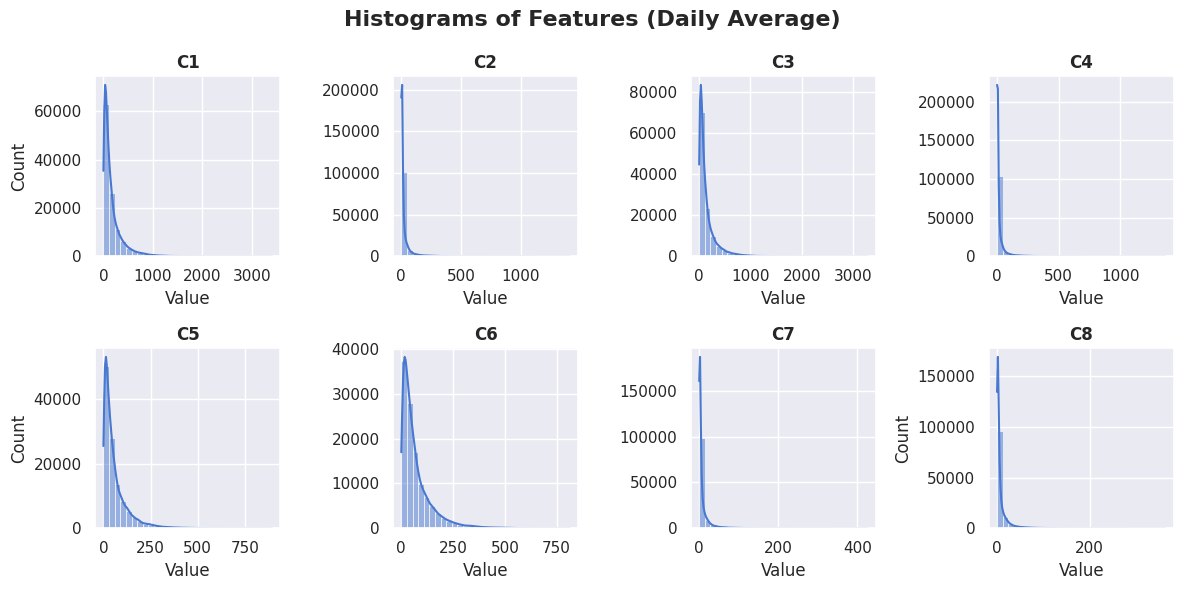

In [35]:
# exclude column 'Grid_ID' from the dataframe
df = daily_mean[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']]

# set Seaborn style and context
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook')

# create a 2x4 grid of subplots for each column
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# loop through each column and create a histogram in a separate subplot
for i, col_name in enumerate(df.columns):
    row = i // 4
    col = i % 4
    sns.histplot(ax=axs[row, col], data=df[col_name], bins=30, kde=True, alpha=0.5, multiple='stack')
    axs[row, col].set_title(col_name, fontweight='bold')
    axs[row, col].set_xlabel("Value")

    # Only show the y label to the plots on the left side
    if col_name in ['C1', 'C5']:
        axs[row, col].set_ylabel('Count')
    else:
        axs[row, col].set_ylabel('')

# set the titles and labels for the plot
plt.suptitle("Histograms of Features (Daily Average)", fontsize=16, fontweight='bold')
plt.xlabel("Value")
plt.ylabel("Count")
fig.tight_layout()

# show the plot
plt.show()

Long tails for some of these features!

# Spatial EDA

In [56]:
hourly_mean.head()

,Grid_ID,Hour,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Day,Month,Weekday
0,1,0,2022-10-14 18:40:07.826086912+00:00,2.388290,0.252464,2.126638,0.238290,0.577159,0.703449,0.050203,0.029304,15.223188,9.973913,3.037681
1,1,1,2022-10-14 21:11:20.232558336+00:00,2.515116,0.224855,2.299273,0.196395,0.906686,0.491483,0.037500,0.029128,15.197674,9.976744,3.034884
2,1,2,2022-10-14 22:11:20.232558336+00:00,3.407296,0.163808,3.097733,0.154157,0.489360,0.405901,0.044797,0.008634,15.197674,9.976744,3.034884
3,1,3,2022-10-15 04:26:31.691394816+00:00,4.577597,0.247448,4.366944,0.241395,0.982908,0.339496,0.065875,0.021306,15.068249,9.988131,3.008902
4,1,4,2022-10-15 04:22:30+00:00,3.380060,0.262530,3.314315,0.248869,0.545506,0.355179,0.013661,0.015565,15.023810,9.988095,3.000000


In [57]:
# Pivot the result to have hours as columns for c1
c1_hourly_mean_pivot = hourly_mean.pivot_table(values='C1', index='Grid_ID', columns='Hour').reset_index()

In [79]:
c1_hourly_mean_pivot.head()

Hour,Grid_ID,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,2.388290,2.515116,3.407296,4.577597,3.380060,3.141707,2.832411,3.852946,2.574107,...,5.427384,5.291347,5.899186,5.584323,4.741149,3.584684,3.400684,3.808977,2.785739,2.897213
1,2,3.599652,3.002180,2.109070,1.784451,2.665476,2.491138,3.898690,5.021131,5.063393,...,8.998517,8.947736,12.492267,8.833112,5.567902,5.030115,4.611880,3.405057,4.759432,4.775603
2,3,3.013768,2.471919,2.112442,2.459139,3.126667,3.644311,5.829048,7.880595,9.194821,...,15.788546,13.695444,20.755785,17.321614,10.579569,9.909540,7.013989,6.147955,6.315057,4.810144
3,4,3.778754,3.497907,3.481744,3.747389,3.360208,3.031317,3.488542,5.453631,8.042202,...,19.672326,16.608052,15.678721,13.889251,10.985172,9.726494,7.370541,8.819432,4.752983,3.967931
4,5,15.694638,16.703517,15.888605,13.346577,14.437054,15.207754,16.931994,17.432500,16.878988,...,37.608023,34.410630,32.866337,31.271902,25.144828,20.498649,17.323248,15.146733,14.183153,14.680115


In [87]:
# Merge the grid geometry and hourly average values;
# This will create a dataframe that has (besides other things) the grid id,
# the grid_id geometry, and the values for C1 from hour 0 to hour 23 (average of the 3 months)
grid_gdf = grid_gdf.merge(c1_hourly_mean_pivot, on='Grid_ID')

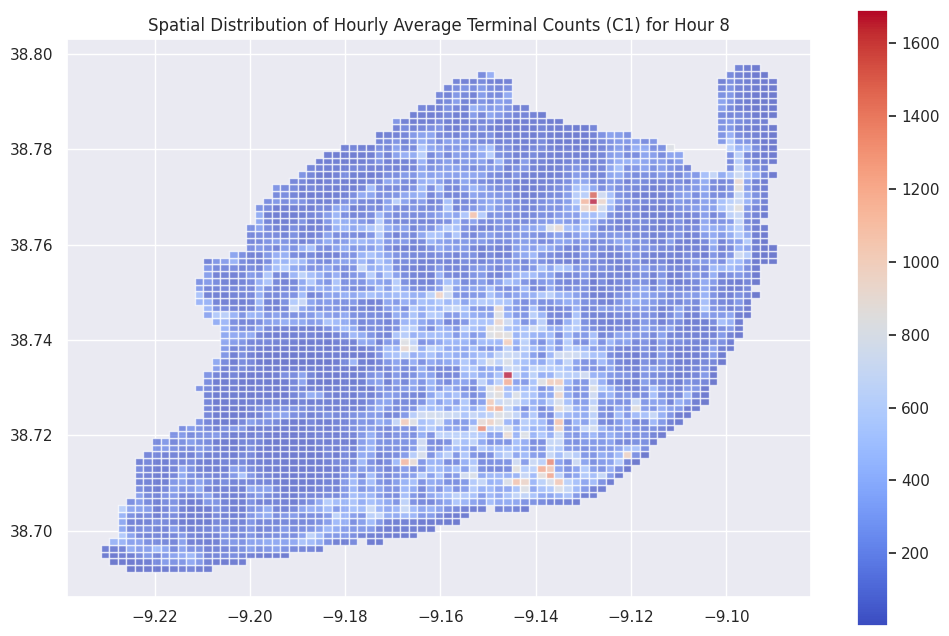

In [99]:
# Plot the C1 values for a specific hour (e.g., hour 12)
hour_to_plot = 8
fig, ax = plt.subplots(figsize=(12, 8))
grid_gdf.plot(column=hour_to_plot, cmap='coolwarm', legend=True, alpha=0.7, ax=ax)
plt.title(f'Spatial Distribution of Hourly Average Terminal Counts (C1) for Hour {hour_to_plot}')
plt.show()

In [113]:
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

/tmp/ipykernel_8321/2226878670.py:20: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


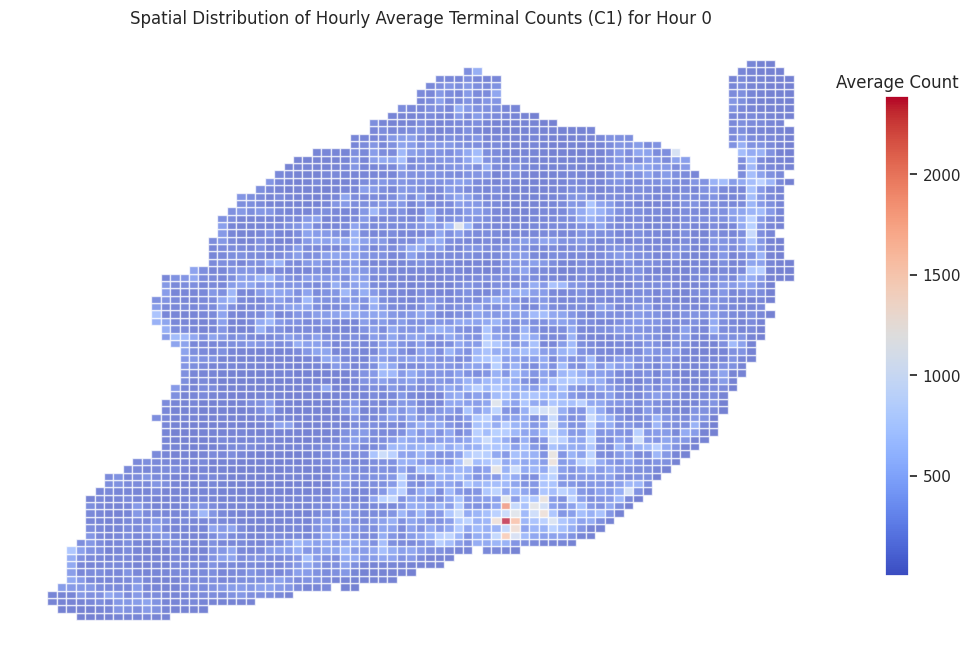

In [112]:
# Create the animation with a single axis for the map
def create_animation():
    fig, ax_map = plt.subplots(figsize=(12, 8))
    cax = fig.add_axes([0.90, 0.2, 0.02, 0.6])  # Adjust the parameters to fit the colorbar inside the GIF
    colorbar_added = False

    def init():
        return update_heatmap(0),

    def update_heatmap(hour):
        nonlocal colorbar_added

        ax_map.clear()

        plot = grid_gdf.plot(column=hour, cmap='coolwarm', alpha=0.7, ax=ax_map)

        if not colorbar_added:
            cbar = fig.colorbar(plot.get_children()[0], cax=cax)
            cbar.set_alpha(1)
            cbar.draw_all()
            cax.set_title("Average Count")
            colorbar_added = True

        ax_map.set_title(f'Spatial Distribution of Hourly Average Terminal Counts (C1) for Hour {hour}')
        ax_map.set_axis_off()

        return ax_map,

    ani = animation.FuncAnimation(fig, update_heatmap, frames=range(0, 24), init_func=init, interval=1000, blit=False)
    return ani

# Create the animation
ani = create_animation()

# Save the animation as a GIF
ani.save('hourly_heatmap_animation.gif', writer=PillowWriter(fps=1))